In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import seaborn as sns
from sklearn.utils import resample
from imblearn.over_sampling import SMOTENC,RandomOverSampler,KMeansSMOTE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
sns.set()

In [3]:
data  = pd.read_csv('data\hypothyroid.csv')

In [4]:
data.shape

(3772, 30)

In [5]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,negative


In [6]:
data.describe()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
count,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,...,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772
unique,94,3,2,2,2,2,2,2,2,2,...,2,242,2,147,2,235,1,1,5,4
top,59,F,f,f,f,f,f,f,f,f,...,t,?,t,?,t,?,f,?,other,negative
freq,95,2480,3308,3722,3729,3625,3719,3719,3713,3538,...,3541,231,3385,387,3387,385,3772,3772,2201,3481


We can see from the data description that there are no missing values. But if you check the dataset the missing values are replaced with invalid values like '?'. Let's replace such values with 'nan' and check for missing values again.

In [7]:
for column in data.columns:
    count = data[column][data[column]=='?'].count()
    if count!=0:
        print(column, data[column][data[column]=='?'].count())
    

age 1
sex 150
TSH 369
T3 769
TT4 231
T4U 387
FTI 385
TBG 3772


So these are the columns which have missing values but missing values are replaced with '?'. We will replace these values with 'nan' and then do imputation of these missing values. 

Also, we can see thatfor column 'TBG' all the values are missing. So we will drop this column as it is of no use to us.

In [8]:
data = data.drop(['TBG'],axis =1)

Also, looking to the dataset, we can see that some columns are with true and false value are just the indication that whether the next column has values or not. Let's see an example:

In [9]:
data[['T4U_measured','T4U']] 

,T4U_measured,T4U
0,t,1.14
1,f,?
2,t,0.91
3,f,?
4,t,0.87
...,...,...
3767,f,?
3768,t,1.08
3769,t,1.07
3770,t,0.94


Since, we are any ways going to handle the missing values, there is no point of having such columns in our dataset.

Let's drop such columns as well.

In [10]:
data = data.drop(['TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured','TBG_measured'],axis =1)

In [11]:
# Now let's replace the '?' values with numpy nan
for column in data.columns:
    count = data[column][data[column]=='?'].count()
    if count!=0:
        data[column] = data[column].replace('?',np.nan)    

In [12]:
for column in data.columns:
    count = data[column][data[column]=='?'].count()
    if count==0:
        print(column, data[column][data[column]=='?'].count())    

age 0
sex 0
on_thyroxine 0
query_on_thyroxine 0
on_antithyroid_medication 0
sick 0
pregnant 0
thyroid_surgery 0
I131_treatment 0
query_hypothyroid 0
query_hyperthyroid 0
lithium 0
goitre 0
tumor 0
hypopituitary 0
psych 0
TSH 0
T3 0
TT4 0
T4U 0
FTI 0
referral_source 0
Class 0


Great!! Now that we have replaced all such values with 'nan'. Let's deal with these missing values now.

In [13]:
data.isna().sum()

age                            1
sex                          150
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                          369
T3                           769
TT4                          231
T4U                          387
FTI                          385
referral_source                0
Class                          0
dtype: int64

Since the values are categorical, we have to change them to numerical before we use any imputation techniques.

We can use get dummies but since most of the columns have only two distinct categories we will use mapping for them. Because since there are only two categories then the two columns formed after get dummies will both have very high correaltion since they both explain the same thing. So in anyway we will have to drop one of the columns. That's why let's use mapping for such columns.
For columns with more than two categories we will use get dummies.

In [18]:
# for column in data.columns:
#     print(column, (data[column].unique()))

In [14]:
# We can map the categorical values like below:
data['sex'] = data['sex'].map({'F' : 0, 'M' : 1})

# except for 'Sex' column all the other columns with two categorical data have same value 'f' and 't'.
# so instead of mapping indvidually, let's do a smarter work
for column in data.columns:
    if  len(data[column].unique())==2:
        data[column] = data[column].map({'f' : 0, 't' : 1})
        
# this will map all the rest of the columns as we require. Now there are handful of column left with more than 2 categories. 


In [15]:
data['referral_source'].unique()

array(['SVHC', 'other', 'SVI', 'STMW', 'SVHD'], dtype=object)

In [16]:
# we will use get_dummies with that.
data = pd.get_dummies(data, columns=['referral_source'])

Now our ouptut class also has 4 distinct categories. There is no sense of using get dummies with our Output class, so we will just map them.
Let's use LabelEncoder function for this.

In [17]:
data['Class'].unique()

array(['negative', 'compensated_hypothyroid', 'primary_hypothyroid',
       'secondary_hypothyroid'], dtype=object)

In [18]:
lblEn = LabelEncoder()

data['Class'] =lblEn.fit_transform(data['Class'])

In [19]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4,T4U,FTI,Class,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,41,0.0,0,0,0,0,0,0,0,0,...,2.5,125,1.14,109,1,False,True,False,False,False
1,23,0.0,0,0,0,0,0,0,0,0,...,2,102,NaN,NaN,1,False,False,False,False,True
2,46,1.0,0,0,0,0,0,0,0,0,...,NaN,109,0.91,120,1,False,False,False,False,True
3,70,0.0,1,0,0,0,0,0,0,0,...,1.9,175,NaN,NaN,1,False,False,False,False,True
4,70,0.0,0,0,0,0,0,0,0,0,...,1.2,61,0.87,70,1,False,False,False,True,False


In [20]:
data.describe(include='all')

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4,T4U,FTI,Class,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
count,3771,3622.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,...,3003,3541,3385,3387,3772.000000,3772,3772,3772,3772,3772
unique,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,69,241,146,234,NaN,2,2,2,2,2
top,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,101,0.99,100,NaN,False,False,False,False,True
freq,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,238,71,95,73,NaN,3660,3386,3733,2738,2201
mean,NaN,0.315295,0.123012,0.013256,0.011400,0.038971,0.014051,0.014051,0.015642,0.062036,...,NaN,NaN,NaN,NaN,0.974814,NaN,NaN,NaN,NaN,NaN
std,NaN,0.464698,0.328494,0.114382,0.106174,0.193552,0.117716,0.117716,0.124101,0.241253,...,NaN,NaN,NaN,NaN,0.279508,NaN,NaN,NaN,NaN,NaN
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN


In [451]:
# for column in data.columns:
#     print(column, (data[column].unique()))

Great! Now that we have encoded all our Categorical values. Let's start with imputing the missing values.

In [21]:
imputer=KNNImputer(n_neighbors=3, weights='uniform',missing_values=np.nan)
new_array=imputer.fit_transform(data) # impute the missing values
    # convert the nd-array returned in the step above to a Dataframe
new_data=pd.DataFrame(data=np.round(new_array), columns=data.columns)

In [22]:
new_data.describe()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4,T4U,FTI,Class,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
count,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,...,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000
mean,51.730912,0.306999,0.123012,0.013256,0.011400,0.038971,0.014051,0.014051,0.015642,0.062036,...,2.032609,108.434517,1.020944,110.300901,0.974814,0.029692,0.102333,0.010339,0.274125,0.583510
std,20.084612,0.461310,0.328494,0.114382,0.106174,0.193552,0.117716,0.117716,0.124101,0.241253,...,0.789917,34.897223,0.165546,32.106052,0.279508,0.169760,0.303126,0.101169,0.446131,0.493042
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,88.000000,1.000000,93.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,104.000000,1.000000,107.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,67.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,124.000000,1.000000,124.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,455.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,11.000000,430.000000,2.000000,395.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
new_data.isna().sum()

age                          0
sex                          0
on_thyroxine                 0
query_on_thyroxine           0
on_antithyroid_medication    0
sick                         0
pregnant                     0
thyroid_surgery              0
I131_treatment               0
query_hypothyroid            0
query_hyperthyroid           0
lithium                      0
goitre                       0
tumor                        0
hypopituitary                0
psych                        0
TSH                          0
T3                           0
TT4                          0
T4U                          0
FTI                          0
Class                        0
referral_source_STMW         0
referral_source_SVHC         0
referral_source_SVHD         0
referral_source_SVI          0
referral_source_other        0
dtype: int64

Great! Now there are no missing values in our new dataset. 


Let's check the distribution for our continous data in the dataset:

C:\Users\nirma\AppData\Local\Temp\ipykernel_32804\3585675561.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_data[column])
C:\Users\nirma\AppData\Local\Temp\ipykernel_32804\3585675561.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_data[column])
C:\Users\nirma\AppData\Local\Temp\

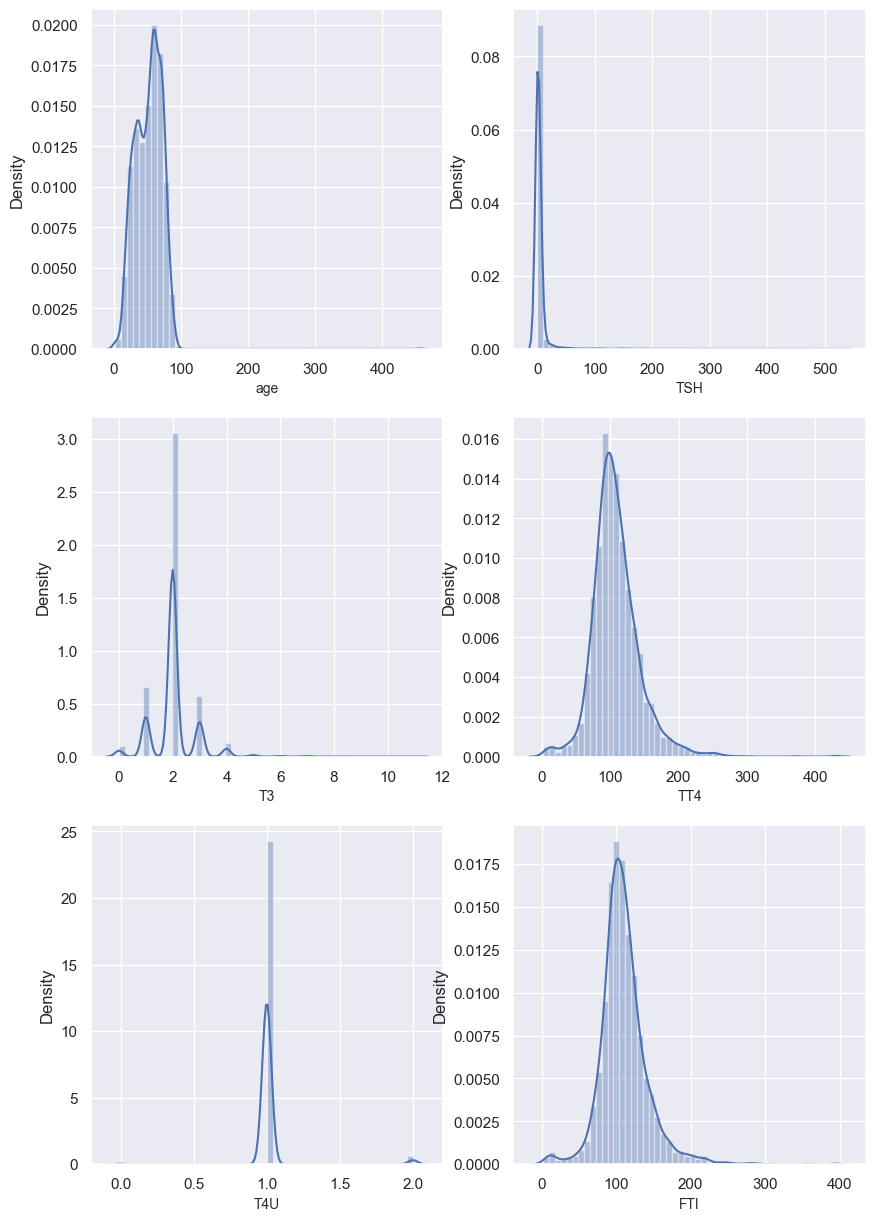

In [ ]:
columns = ['age','TSH','T3','TT4','T4U','FTI']

plot.figure(figsize=(10,15),facecolor='white')
plotnumber = 1

for column in columns:
    ax = plot.subplot(3,2,plotnumber)
    sns.distplot(new_data[column])
    plot.xlabel(column,fontsize=10)
    plotnumber+=1
plot.show()

The graphs for age, TSH and T3 looks heavely skewed towards left. Let's do some transformations to the data and see if it improves the plot.

Before doing log transformation , let's add 1 to each valuue in the column to handle exception when we try to find log of '0'.

C:\Users\nirma\AppData\Local\Temp\ipykernel_32804\4022235021.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(new_data[column]))
C:\Users\nirma\AppData\Local\Temp\ipykernel_32804\4022235021.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(new_data[column]))
C:\Users\nirma\App

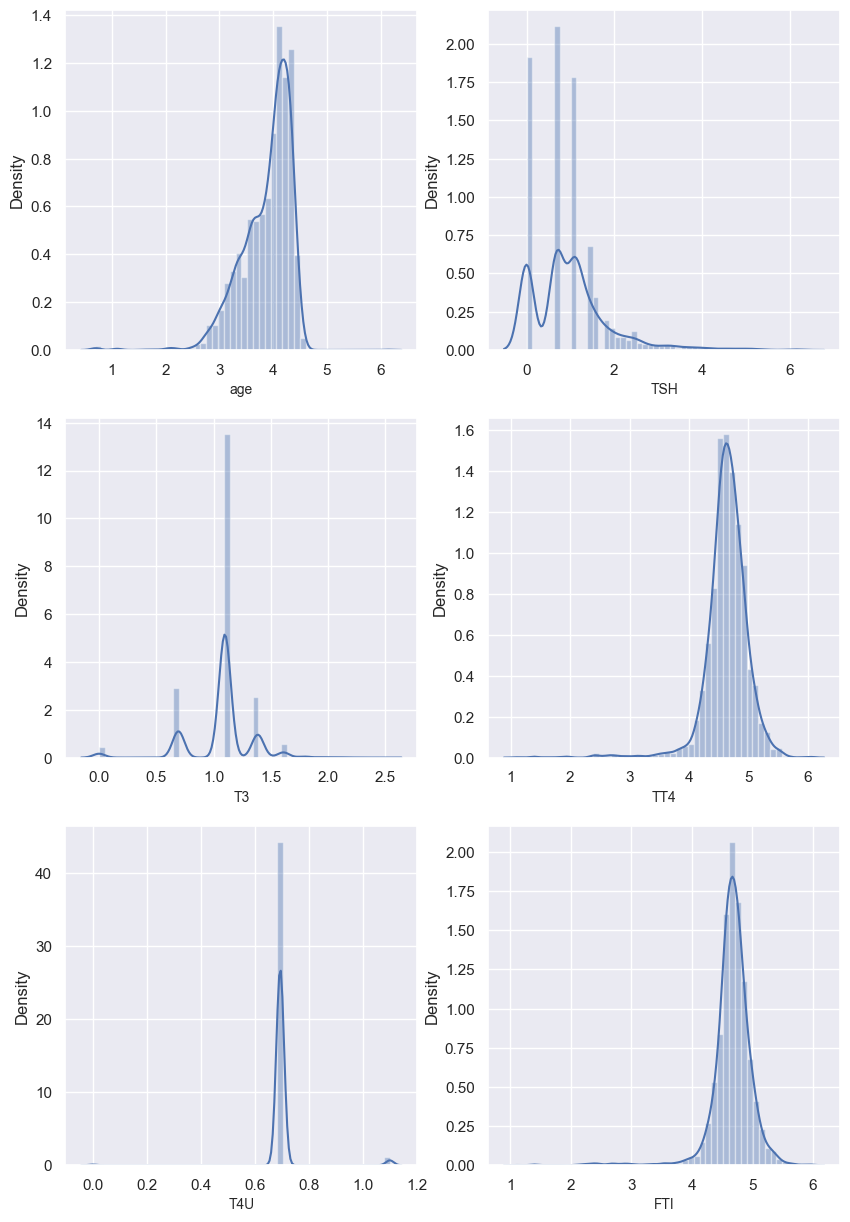

In [25]:
columns = ['age','TSH','T3','TT4','T4U','FTI']

plot.figure(figsize=(10,15),facecolor='white')
plotnumber = 1

for column in columns:
    new_data[column]+=1
    ax = plot.subplot(3,2,plotnumber)
    sns.distplot(np.log(new_data[column]))
    plot.xlabel(column,fontsize=10)
    plotnumber+=1
plot.show()


After log transformation, rest of the columns look fine but 'TSH' has a weird trend.

It won't give much of information so let's drop this column.

In [26]:
new_data = new_data.drop(['TSH'],axis=1)


#### let's see how balanced our dataset in terms of given target classes:

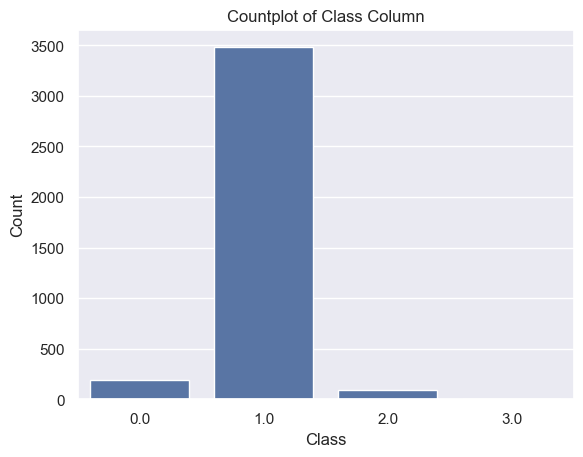

In [30]:
# let's see how data is distributed for every column for every individual id
# the graph plot below is for individual ids. Press 1 in the  input box below the graph to continue viewing graph for each id!!

# plot.figure(figsize=(20,25), facecolor='white')
# plotnumber = 1
# plt_data = data.drop(['age'], axis =1)

# for column in plt_data:
#     ax = plot.subplot(6,5,plotnumber)
#     sns.countplot(plt_data[column])
#     plot.xlabel(column,fontsize=10)
#     plotnumber+=1
# plot.show()

sns.countplot(x=new_data['Class'], data=new_data)
plot.title('Countplot of Class Column')
plot.xlabel('Class')
plot.ylabel('Count')
plot.show()
        
    

We can clerly see that the dataset is highly imbalanced. 

We will use a python library known as imbalanced-learn to deal with imbalanced data.
Imbalanced learn has an algorithm called RandomOverSampler.

Note: https://pypi.org/project/imbalanced-learn/

https://github.com/scikit-learn-contrib/imbalanced-learn


Also, ensemble techniques are well versed in handling such imbalanced data.

In [474]:
# cat = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# sm = SMOTENC(categorical_features = cat,sampling_strategy='minority',k_neighbors=3)

In [422]:
# kmsmote=KMeansSMOTE()

In [32]:
x = new_data.drop(['Class'],axis=1)
y = new_data['Class']
rdsmple = RandomOverSampler()
x_sampled,y_sampled  = rdsmple.fit_resample(x,y)

In [ ]:
# x_sampled,y_sampled = kmsmote.fit_sample(x,np.asarray(y))

In [34]:
x_sampled.shape

(13924, 25)

In [35]:
x_sampled = pd.DataFrame(data = x_sampled, columns = x.columns)

In [36]:
x_sampled

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,psych,T3,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,126.0,2.0,110.0,0.0,1.0,0.0,0.0,0.0
1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,103.0,2.0,109.0,0.0,0.0,0.0,0.0,1.0
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,110.0,2.0,121.0,0.0,0.0,0.0,0.0,1.0
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,176.0,2.0,178.0,0.0,0.0,0.0,0.0,1.0
4,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,62.0,2.0,71.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13919,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,3.0,23.0,2.0,58.0,0.0,0.0,0.0,0.0,1.0
13920,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,3.0,23.0,2.0,58.0,0.0,0.0,0.0,0.0,1.0
13921,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0
13922,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0


<Axes: xlabel='Class', ylabel='count'>

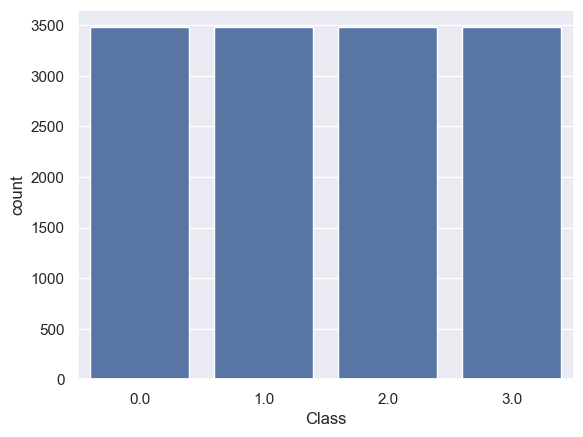

In [38]:
sns.countplot(x=y_sampled, data=x_sampled)


     
    

Our dataset looks balanced now. We can go ahead with training our model on this data.